# Natural Language Processing en Pytorch

In [10]:
import torch

## Tutorial 2: Implementación de Skip-Gram Word2Vec

El objetivo es calcular la probabilidad de $P(\mathbf{O}|\mathbf{C})$ (probabilidad de las palabras de alrededor dada la palabra centra).

Podemos aproximar esta probabilidad con un modelo de Softmax:

$$
P(\mathbf{O}=o|\mathbf{C}=c) = \frac{\exp(\Theta x_c)}{\sum_{w\in Vocab}\exp(\theta_w^T x_c)}
$$

donde 

$$
\Theta = 
\begin{bmatrix}
-\;\theta_1^T \;- \\
-\; \theta_2^T \;- \\
\vdots \\
-\; \theta_{|V|}^T \; -
\end{bmatrix}
$$

y $x_c$ es un *one-hot* vector en la palabra $c$ del vocabulario $V$.
Si se define

$$
\Theta = U V
$$

con 

$$
\begin{align}
U = 
\begin{bmatrix}
- \; u_1^T \; - \\
- \; u_2^T \; - \\
\vdots \\
- \; u_{|V|}^T \; -
\end{bmatrix} & &
V = 
\begin{bmatrix}
| & | & & | \\
v_1 & v_2 & \cdots & v_{|V|} \\
| & | & & | \\
\end{bmatrix} & & 
u_i , v_i \in \mathbb{R}^{n} \; i= 1, \ldots, |V|
\end{align}
$$

puede verse que la expresión de la probabilidad condicional anterior queda

$$
\begin{align}
P(\mathbf{O}=o|\mathbf{C}=c) &= \frac{\exp(\Theta c)}{\sum_{w\in V}\exp(\theta_w^T c)} \\[.5em]
&= \frac{\exp(u_o^T v_c)}{\sum_{w\in V}\exp(u_w^T v_c)}
\end{align}
$$

donde $v_c$ es la columna de $V$ correspondiente a la plabra $c$ del vocabulario y $u_o^T$ es la fila $o$ de $U$ correspondiente a la palabra $o$ del vocabulario.

El siguiente paso es encontrar los parámetros de la distribución anterior, lo cual se hará minimizando la función de costo *Negative LogLikelihood* por gradiente estocástico. Para eso, se puede utilizar las relaciones

$$
\begin{align}
\frac{\partial J}{\partial U} = \frac{\partial J}{\partial \Theta} V^T & \hspace{3em} &
\frac{\partial J}{\partial V} = U^T \frac{\partial J}{\partial \Theta} 
\end{align}
$$

con $J(U,V) = NLL(P(o|c))$, o hacer el cálculo a mano a partir de la expresión completa:

$$
\begin{align}
J(U,V) &= - \log \left( \prod_{i=1}^N \prod_{j=1}^{|V|} P(o_i = j | x_i)^{\mathbb{1}_{\{y_i = j\} }} \right) \\
&= 
\end{align}
$$


In [144]:
class Stanford(torch.utils.data.Dataset):
    
    def __init__(self, path, samples='Train', context_size=2):
        
        super(Stanford, self).__init__()
        
        self.context_size = context_size
        
        sentences = []
        with open(path + "/datasetSentences.txt", "r") as f:
            first = True
            for line in f:
                if first:
                    first = False
                    continue

                splitted = line.strip().split()[1:]
                # Deal with some peculiar encoding issues with this file
                sentences += [[w.lower() for w in splitted]]
        
        split = [[] for i in range(3)]
        with open(path + "/datasetSplit.txt", "r") as f:
            first = True
            for line in f:
                if first:
                    first = False
                    continue

                splitted = line.strip().split(",")
                split[int(splitted[1]) - 1] += [int(splitted[0]) - 1]
        
        if samples == 'Train':
            self.samples = self.getSamples(split[0], sentences)
        elif samples == 'Validation':
            self.samples = self.getSamples(split[1], sentences)
        elif samples == 'Test':
            self.samples = self.getSamples(split[2], sentences)
        else:
            print('Error: especificar si las muestras son de train, validation o test')
            self.samples = None
        
        # Get the tokens:
        tokens = dict()
        tokenfreq = dict()
        revtokens = []
        idx = 0
        for sentence in sentences:
            for w in sentence:
                if not w in tokens:
                    tokens[w] = idx
                    revtokens += [w]
                    tokenfreq[w] = 1
                    idx += 1
                else:
                    tokenfreq[w] += 1
        tokens["<UNK>"] = idx
        revtokens += ["<UNK>"]
        tokenfreq["<UNK>"] = 1
        tokens["<PAD>"] = idx + 1
        revtokens += ["<PAD>"]
        tokenfreq["<PAD>"] = 1

        self.word_to_index = tokens
        self.index_to_word = {idx: word for word, idx in zip(tokens.keys(),tokens.values())}
        self.vocabulary = list(revtokens)
        self.tokens_freqs = tokenfreq
        
    def getSamples(self, corpus, sentences):
        samples = []
        pad_token = '<PAD>'
        for sentence_idx in corpus:
            sentence = sentences[sentence_idx]
            for i, word in enumerate(sentence):
                first_context_word_index = max(0,i-self.context_size)
                last_context_word_index = min(i+self.context_size+1, len(sentence))
                
                context = [pad_token for j in range(i-self.context_size,first_context_word_index)] + \
                          sentence[first_context_word_index:i] + \
                          sentence[i+1:last_context_word_index] + \
                          [pad_token for j in range(last_context_word_index,i+self.context_size+1)]
                
                samples.append((word, context))
                
        return samples
    
    
    def __len__(self):
        return len(self.samples)

    
    def __getitem__(self, idx):
        
        word, context = self.samples[idx]
        idx_context = torch.empty(len(context), dtype=torch.long)
        idx_word = torch.tensor(self.word_to_index[word], dtype=torch.long)
        for i, w in enumerate(context):
            idx_context[i] = self.word_to_index[w]

        return idx_word, idx_context
    
    
train_dataset = Stanford(path='../04-Prueba-standarization/StanfordDataset/datasets/stanfordSentimentTreebank',
                         samples='Train', context_size=4)

val_dataset = Stanford(path='../04-Prueba-standarization/StanfordDataset/datasets/stanfordSentimentTreebank',
                       samples='Validation', context_size=4)

test_dataset = Stanford(path='../04-Prueba-standarization/StanfordDataset/datasets/stanfordSentimentTreebank',
                        samples='Test', context_size=4)


batch_size = 64 # Tamaño del batch
NUM_TRAIN = len(train_dataset) # Cantidad de muestras de entrenamiento
NUM_VAL = len(val_dataset) # Cantidad de muestras para validación
sampler = lambda start, end: torch.utils.data.SubsetRandomSampler(range(start, end)) # Función para mezclar aleatoriamente las muestras


# Dataloader para las muestras de entrenamiento:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, 
                                               sampler=sampler(0, NUM_TRAIN))

# Dataloader para las muestras de validación:
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                             batch_size=batch_size, 
                                             sampler=sampler(0, NUM_VAL))

# Dataloader para las muestras de testeo:
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size)

In [145]:
import torch.nn as nn

class SkipGram(nn.Module):
    
    def __init__(self, n_vectors, embedding_dim):
        
        super(SkipGram, self).__init__()
        self.emb = nn.Embedding(n_vectors, embedding_dim)
        self.linear = nn.Linear(embedding_dim, n_vectors)
        
    def forward(self, x):
        emb = self.emb(x)
        scores = self.linear(emb)
        return scores
    
    def loss(self, scores, target):
        cross_entropy = nn.CrossEntropyLoss()
        mean_loss = 0 
        context_size = target.size()[1]
        for i in range(context_size):
            mean_loss += cross_entropy(scores, target[:,i])
        return mean_loss / context_size
    
embedding_dim = 50
tokens = train_dataset.word_to_index
nWords = len(train_dataset.vocabulary)
model = SkipGram(nWords, embedding_dim)

In [146]:
import torch.optim as optim

def CheckAccuracy(loader, model, device, input_dtype, target_dtype):  
    num_correct = 0
    num_samples = 0
    model.eval()  
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=input_dtype)  
            y = y.to(device=device, dtype=target_dtype)
            
            scores = model(x)
            _, preds = scores.max(dim=1)
            num_correct += torch.tensor([(preds == y[:,i]).sum() for i in range(y.size()[1])]).sum()
            num_samples += preds.size(0)

        return num_correct, num_samples
        

def TrainModel(model, data, epochs=1, learning_rate=1e-2, sample_loss_every=100):
    
    input_dtype = data['input_dtype'] 
    target_dtype = data['target_dtype']
    device = data['device']
    train_dataloader = data['train_dataloader']
    val_dataloader = data['val_dataloader']
    
    performance_history = {'iter': [], 'loss': [], 'accuracy': []}
    
    model = model.to(device=device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    batch_size = len(train_dataloader)
    for e in range(epochs):
        for t, (x,y) in enumerate(train_dataloader):
            model.train()
            x = x.to(device=device, dtype=input_dtype)
            y = y.to(device=device, dtype=target_dtype)

            # Forward pass
            scores = model(x) 
            
            # Backward pass
            loss = model.loss(scores,y)                 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (e * batch_size + t) % sample_loss_every == 0:
                num_correct, num_samples = CheckAccuracy(val_dataloader, model, device, input_dtype, target_dtype)
                performance_history['iter'].append(t)
                performance_history['loss'].append(loss.item())
                performance_history['accuracy'].append(float(num_correct) / num_samples)
                print('Epoch: %d, Iteration: %d, Accuracy: %d/%d ' % (e, t, num_correct, num_samples))
                
    num_correct, num_samples = CheckAccuracy(val_dataloader, model, device, input_dtype, target_dtype)
    print('Final accuracy: %.2f%%' % (100 * float(num_correct) / num_samples) )
    
    return performance_history

In [153]:
# Especificaciones de cómo adquirir los datos para entrenamiento:
use_gpu = True
if torch.cuda.is_available() and use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

data = {
    'device': device,
    'input_dtype': torch.long,
    'target_dtype': torch.long,
    'train_dataloader': train_dataloader,
    'val_dataloader': val_dataloader
}

# Hiperparámetros del modelo y otros:
epochs = 1 # Cantidad de epochs
sample_loss_every = 10 # Cantidad de iteraciones para calcular la cantidad de aciertos
learning_rate = 1e-2 # Tasa de aprendizaje

# Entrenamiento:
performance_history = TrainModel(model, data, epochs, learning_rate, sample_loss_every)

Epoch: 0, Iteration: 0, Accuracy: 44045/42405 
Epoch: 0, Iteration: 10, Accuracy: 44042/42405 
Epoch: 0, Iteration: 20, Accuracy: 44042/42405 
Epoch: 0, Iteration: 30, Accuracy: 44042/42405 
Epoch: 0, Iteration: 40, Accuracy: 44042/42405 
Epoch: 0, Iteration: 50, Accuracy: 44044/42405 
Epoch: 0, Iteration: 60, Accuracy: 44042/42405 
Epoch: 0, Iteration: 70, Accuracy: 44042/42405 
Epoch: 0, Iteration: 80, Accuracy: 44042/42405 
Epoch: 0, Iteration: 90, Accuracy: 44042/42405 
Epoch: 0, Iteration: 100, Accuracy: 44042/42405 
Epoch: 0, Iteration: 110, Accuracy: 44042/42405 
Epoch: 0, Iteration: 120, Accuracy: 44041/42405 
Epoch: 0, Iteration: 130, Accuracy: 44041/42405 
Epoch: 0, Iteration: 140, Accuracy: 44038/42405 
Epoch: 0, Iteration: 150, Accuracy: 44041/42405 
Epoch: 0, Iteration: 160, Accuracy: 44044/42405 
Epoch: 0, Iteration: 170, Accuracy: 44043/42405 
Epoch: 0, Iteration: 180, Accuracy: 44043/42405 
Epoch: 0, Iteration: 190, Accuracy: 44045/42405 
Epoch: 0, Iteration: 200, Accur

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


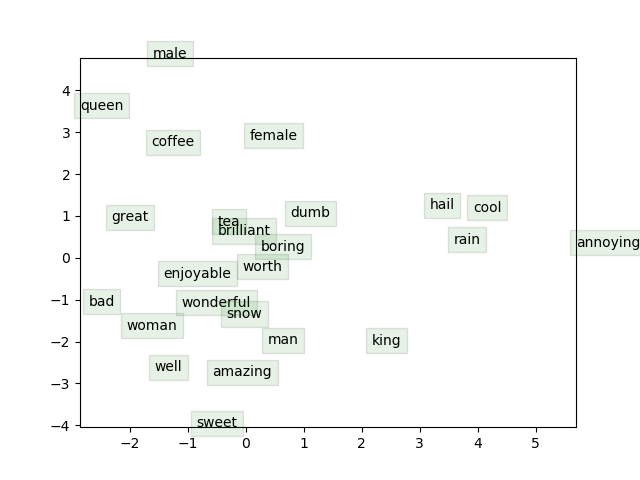

(-4.045593, 4.7819357)

In [154]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

wordVectors = next(iter(model.parameters())).clone().detach().cpu().numpy()
#wordVectors = wordVectors / np.sqrt((wordVectors**2).sum(axis=1)).reshape(-1,1)

visualizeWords = [
    "great", "cool", "brilliant", "wonderful", "well", "amazing",
    "worth", "sweet", "enjoyable", "boring", "bad", "dumb",
    "annoying", "female", "male", "queen", "king", "man", "woman", "rain", "snow",
    "hail", "coffee", "tea"]

visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2])

for i in range(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i],
        bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

<IPython.core.display.Javascript object>


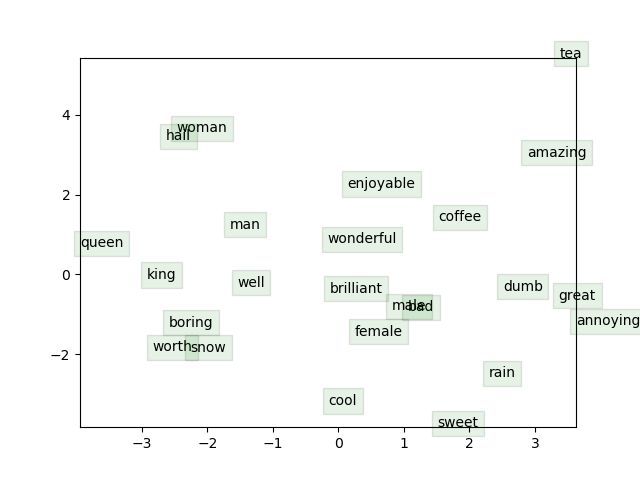

(-3.8278303, 5.429688)

In [141]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

wordVectors = next(iter(model.parameters())).clone().detach().cpu().numpy()
#wordVectors = wordVectors / np.sqrt((wordVectors**2).sum(axis=1)).reshape(-1,1)

visualizeWords = [
    "great", "cool", "brilliant", "wonderful", "well", "amazing",
    "worth", "sweet", "enjoyable", "boring", "bad", "dumb",
    "annoying", "female", "male", "queen", "king", "man", "woman", "rain", "snow",
    "hail", "coffee", "tea"]

visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2])

for i in range(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i],
        bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))